Author: Atticus Patrick

In [24]:
#import necessary packages
import pandas as pd
import matplotlib as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [2]:
#read in data
ski = pd.read_csv("ski_resort_stats.csv")

In [3]:
#filter for New England States
NE = ['Maine', 'New Hampshire ', 'Massachusetts ', 'Vermont', 'Rhode Island', 'Connecticut']
ski_NE = ski.loc[ski['state'].isin(NE)]

In [4]:
#check for any NAs
ski_NE[ski_NE.isna().any(axis = 1)]

,resort_name,state,cost,summit,base,vertical,lifts,runs,acres,green_percent,green_acres,blue_percent,blue_acres,black_percent,black_acres,lat,lon
82,"Black Mountain, ME",Maine,NaN,2460.0,1080.0,1380.0,3.0,35.0,48,NaN,0.00,NaN,0.00,NaN,0.0,45.18,-70.67
84,"Lost Valley, ME",Maine,NaN,NaN,NaN,240.0,2.0,17.0,45,0.30,13.50,0.50,22.50,0.2,9.0,44.12,-70.27
94,"Blanford, MA",Massachusetts,NaN,1685.0,1220.0,465.0,5.0,22.0,158,0.40,63.20,0.50,79.00,0.1,15.8,42.18,-72.93
176,"Granite Gorge, NH",New Hampshire,399.0,NaN,NaN,525.0,2.0,17.0,25,0.35,8.75,0.35,8.75,0.3,7.5,42.97,-72.21


In [5]:
#remove rows with NA
ski_NE1 = ski_NE.dropna()
ski_NE1[ski_NE1.isna().any(axis = 1)]

,resort_name,state,cost,summit,base,vertical,lifts,runs,acres,green_percent,green_acres,blue_percent,blue_acres,black_percent,black_acres,lat,lon


Exploratory Data Analysis

['resort_name', 'state', 'cost', 'summit', 'base', 'vertical', 'lifts', 'runs', 'acres', 'green_percent', 'green_acres', 'blue_percent', 'blue_acres', 'black_percent', 'black_acres', 'lat', 'lon']


<AxesSubplot:>

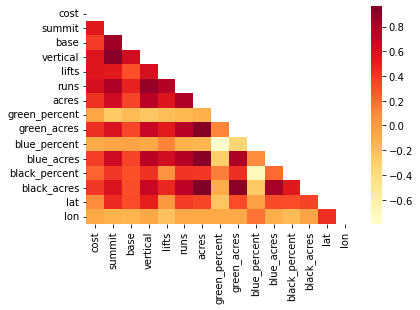

In [6]:
import matplotlib.pyplot as plt

#create correlation matrix
corr = ski_NE1.corr()
labels = []
for col in ski_NE1.columns:
    labels.append(col)
#check labels are stored
print(labels)
# plot correlation matrix
corr = ski_NE1.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=False, mask=matrix, cmap = 'YlOrRd', xticklabels=True, yticklabels=True)

There is plenty of collinearity between the green acres, blue acres, black acres, and acres, so we'll just use acres. Summit appears to have high collinearity with vertical, base, runs, and we'll drop this, we don't need lat and lon either. Green, blue, black trail percentages seem to be irrelevant to cost.

In [7]:
#drop columns that don't give us much information about cost
ski_NE1 = ski_NE1.drop(['lat', 'lon', 'green_acres', 'blue_acres', 'black_acres', 'summit', 'blue_percent', 'green_percent', 'black_percent'], axis = 1)

In [8]:
#check the right columns remain
print(ski_NE1.keys())

Index(['resort_name', 'state', 'cost', 'base', 'vertical', 'lifts', 'runs',
       'acres'],
      dtype='object')


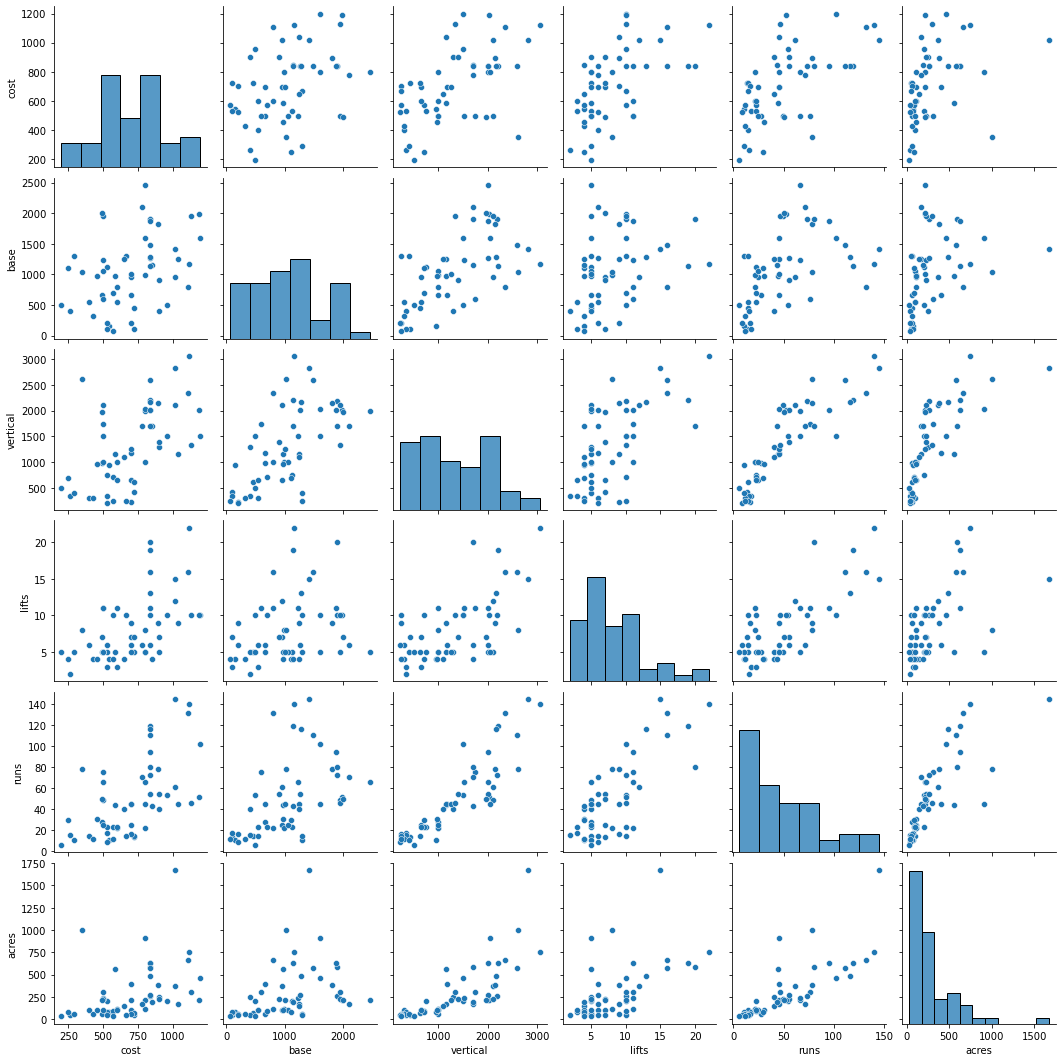

In [10]:
#create a pairplot
ski_NE_pair = ski_NE1.drop(['resort_name','state'], axis = 1)
sns.pairplot(ski_NE_pair)

It looks like runs, lifts, and vertical have a relatively positive, moderate relationship with cost.

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Connecticut'),
  Text(1, 0, 'Maine'),
  Text(2, 0, 'Massachusetts '),
  Text(3, 0, 'New Hampshire '),
  Text(4, 0, 'Rhode Island'),
  Text(5, 0, 'Vermont')])

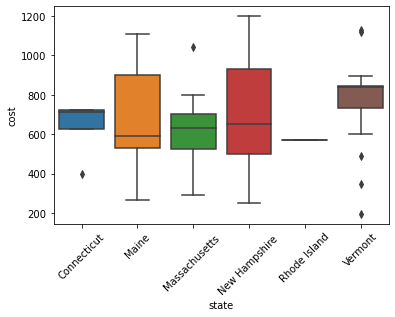

In [11]:
#break down season pass costs by state
sns.boxplot(x = 'state', y = 'cost', data = ski_NE1)
plt.xticks(rotation=45)

Vermont seems to have more expensive costs, but has a big range of costs as well with quite a few outside of the IQR. For the amount of mountains it has to offer, Maine appears to be the most affordable.

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Connecticut'),
  Text(1, 0, 'Maine'),
  Text(2, 0, 'Massachusetts '),
  Text(3, 0, 'New Hampshire '),
  Text(4, 0, 'Rhode Island'),
  Text(5, 0, 'Vermont')])

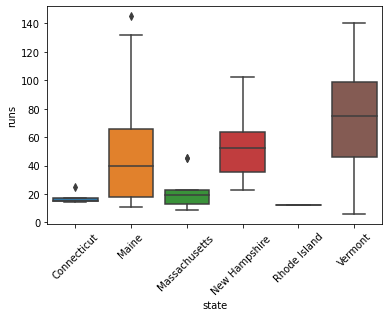

In [12]:
#number of runs by state
sns.boxplot(x = 'state', y = 'runs', data = ski_NE1)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Connecticut'),
  Text(1, 0, 'Maine'),
  Text(2, 0, 'Massachusetts '),
  Text(3, 0, 'New Hampshire '),
  Text(4, 0, 'Rhode Island'),
  Text(5, 0, 'Vermont')])

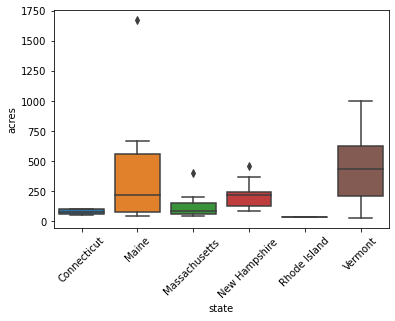

In [13]:
#amount of acres by state
sns.boxplot(x = 'state', y = 'acres', data = ski_NE1)
plt.xticks(rotation=45)

Regression Analysis - can we find what influences season pass cost?

In [52]:
#simple linear regression for cost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, svm
from sklearn.preprocessing import StandardScaler

#split into train and test data
ski_NE2 = ski_NE1.drop(['resort_name','cost','state'], axis = 1)
X = ski_NE2
y = ski_NE1['cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#train and deploy linear model
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_pred = lm.predict(X_test)
np.sqrt(np.mean(np.square(np.subtract(y_test, lm_pred))))

164.4726870822996

In [15]:
#determine the coefficients
coef = lm.coef_
tags = list(ski_NE2.keys())
for i in range(5):
    print('Feature: ' + tags[i] + ', Score: ', end="", flush=True)
    print(coef[i])

Feature: base, Score: 43.64187145126249
Feature: vertical, Score: -4.23262501092789
Feature: lifts, Score: 71.48678709294515
Feature: runs, Score: 112.89460844110387
Feature: acres, Score: -43.780946989909815


The linear model performed decently here, achieving a root mean square error (RMSE) of 164.47 dollars with the test data. The most influential predictors for this model, however, were amount of runs and amount of lifts. This makes sense considering bigger mountains generally charge more.

In [57]:
#ridge regression with cross validation to use the best alpha value
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
regCV = RidgeCV(alphas=[0.1, 1.0, 3.0, 5.0, 7.0, 10.0])
regCV.fit(X_train, y_train)

reg_pred = regCV.predict(X_test)
np.sqrt(np.mean(np.square(np.subtract(y_test, reg_pred))))

158.0630837890502

In [58]:
coef = regCV.coef_
tags = list(ski_NE2.keys())
for i in range(5):
    print('Feature: ' + tags[i] + ', Score: ', end="", flush=True)
    print(coef[i])

Feature: base, Score: 33.53191911032765
Feature: vertical, Score: 24.546089710013966
Feature: lifts, Score: 64.60160266497891
Feature: runs, Score: 59.06719208247028
Feature: acres, Score: -13.351698604464673


In [59]:
#lasso regression with cross validation to use the best alpha value
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
lasCV = LassoCV(alphas=[0.1, 1.0, 3.0, 5.0, 7.0, 10.0])
lasCV.fit(X_train, y_train)

las_pred = lasCV.predict(X_test)
np.sqrt(np.mean(np.square(np.subtract(y_test, las_pred))))

160.0391274621159

In [60]:
coef = lasCV.coef_
tags1 = list(ski_NE2.keys())
for i in range(5):
    print('Feature: ' + tags1[i] + ', Score: ', end="", flush=True)
    print(coef[i])

Feature: base, Score: 35.7185370570225
Feature: vertical, Score: 0.0
Feature: lifts, Score: 69.40609883539396
Feature: runs, Score: 70.05514513214072
Feature: acres, Score: -0.0


Ridge regression improves test RMSE to 158.06 dollars and Lasso regression improves test RMSE to 160.04 dollars. The most influential predictors are yet again runs, lift and base, with vertical and acres having little effect on the cost of season passes. These results indicate the ridge regression model should be able to give a fairly decent estimate of how much a season pass should cost based on a mountain's number of lifts, runs and base.

In [72]:
rfc = RandomForestClassifier(random_state = 0, n_estimators = 50)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)

#calculate root mean squared error as we want results to be interpretable in dollars
np.sqrt(np.mean(np.square(np.subtract(y_test, pred))))

261.3799915831355

The random forest classifier achieves a mean squared error of 261.38 dollars on the test examples, indicating a worse accuracy than the linear models. Ridge regression remains the model with the highest prediction accuracy.